In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
# Load processed dataset
train = pd.read_csv('processed_train.csv', parse_dates=['date'], low_memory=False)


In [3]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,earthquake_impact,avg_store_sales,sales_lag_7,sales_lag_30,rolling_mean_7,rolling_std_7,sales_prev_day,sales_next_day,sales_change_after_holiday,sales_change_before_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,0,254.651925,NaN,NaN,NaN,NaN,NaN,2.0,inf,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,0,254.651925,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,0,254.651925,NaN,NaN,NaN,NaN,NaN,2.0,inf,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,0,254.651925,NaN,NaN,NaN,NaN,NaN,1091.0,inf,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,0,254.651925,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,0,476.819765,358.132,571.333,381.083426,86.433346,283.429,NaN,NaN,54.582982
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,0,476.819765,112.954,125.960,121.605856,16.673439,114.120,NaN,NaN,35.430249
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,0,476.819765,2299.715,2041.967,1525.855714,439.927872,1348.425,NaN,NaN,79.448542
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,0,476.819765,170.000,0.000,144.571429,38.504793,182.000,NaN,NaN,-33.516484


In [4]:
# Baseline Model - Naïve Forecasting
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [5]:
# Prepare training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 
            'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [6]:
# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [7]:
y_train_sample = y_train.iloc[-10000:]  # Use only the last 10,000 records


In [8]:
# Train ARIMA Model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_val))


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [9]:
rf_model = RandomForestRegressor(
    n_estimators=50,  # Reduce trees
    max_depth=10,  # Limit depth
    n_jobs=-1,  # Enable parallelism
    bootstrap=False,  # Reduce overhead
    random_state=42
)

X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state=42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)


In [10]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [11]:
rf_model.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [12]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

In [13]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")
    

print("Model Evaluation:")
if 'arima_preds' in locals():
    evaluate_model(y_val, arima_preds, "ARIMA")
else:
    print("ARIMA predictions not found.")
if "rf_model" in locals():
    rf_preds = rf_model.predict(X_val)
else:
    print("Random Forest model not trained.")

evaluate_model(y_val, arima_preds, "ARIMA")
evaluate_model(y_val, rf_preds, "Random Forest")
evaluate_model(y_val, xgb_preds, "XGBoost")

Model Evaluation:
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


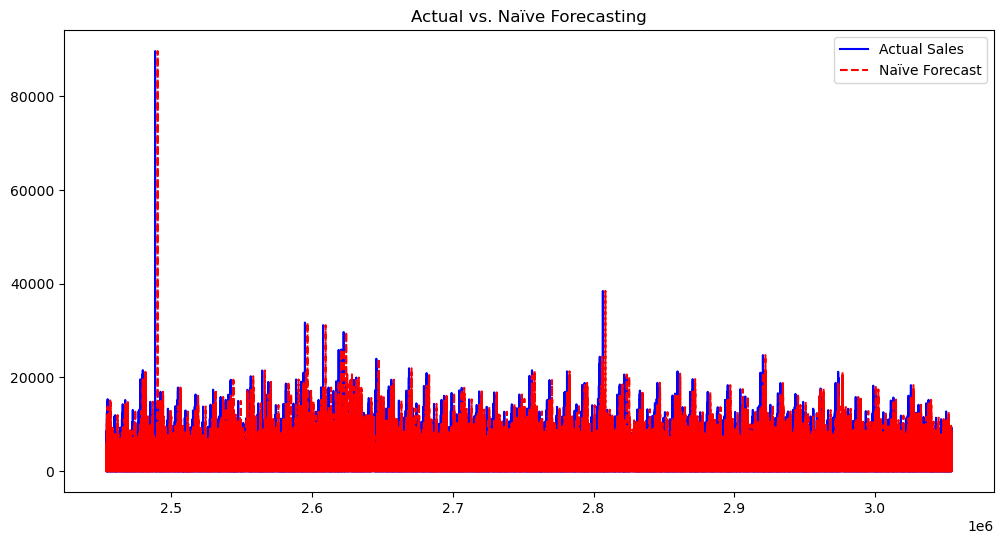

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label="Actual Sales", color='blue')
plt.plot(y_val.index, train.loc[y_val.index, 'naive_forecast'], label="Naïve Forecast", color='red', linestyle='dashed')
plt.title("Actual vs. Naïve Forecasting")
plt.legend()
plt.show()


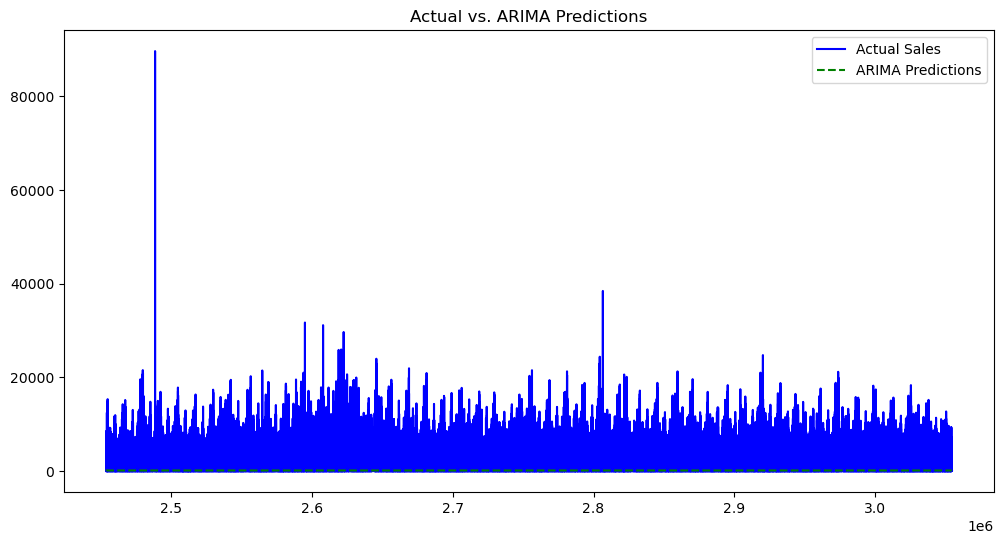

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label="Actual Sales", color='blue')
plt.plot(y_val.index, arima_preds, label="ARIMA Predictions", color='green', linestyle='dashed')
plt.title("Actual vs. ARIMA Predictions")
plt.legend()
plt.show()


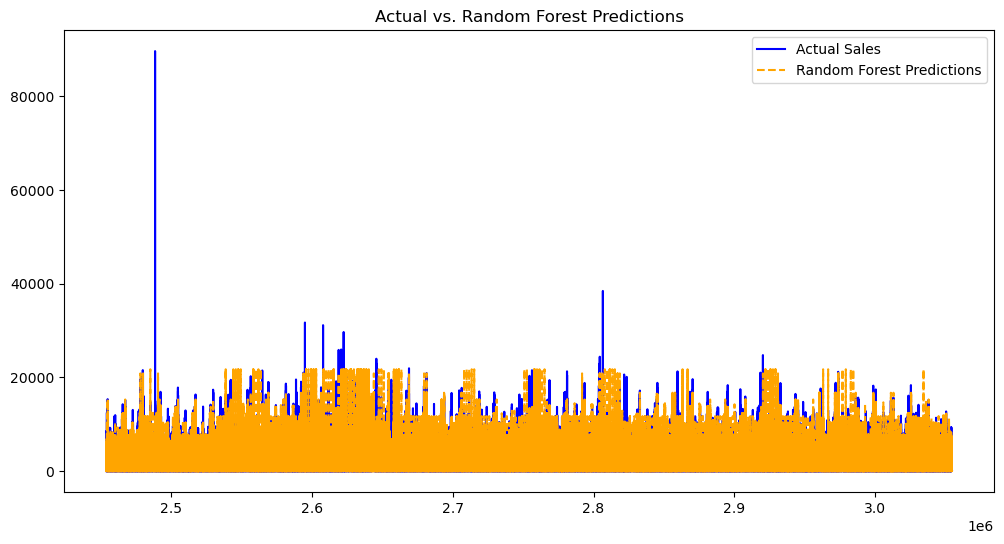

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label="Actual Sales", color='blue')
plt.plot(y_val.index, rf_preds, label="Random Forest Predictions", color='orange', linestyle='dashed')
plt.title("Actual vs. Random Forest Predictions")
plt.legend()
plt.show()


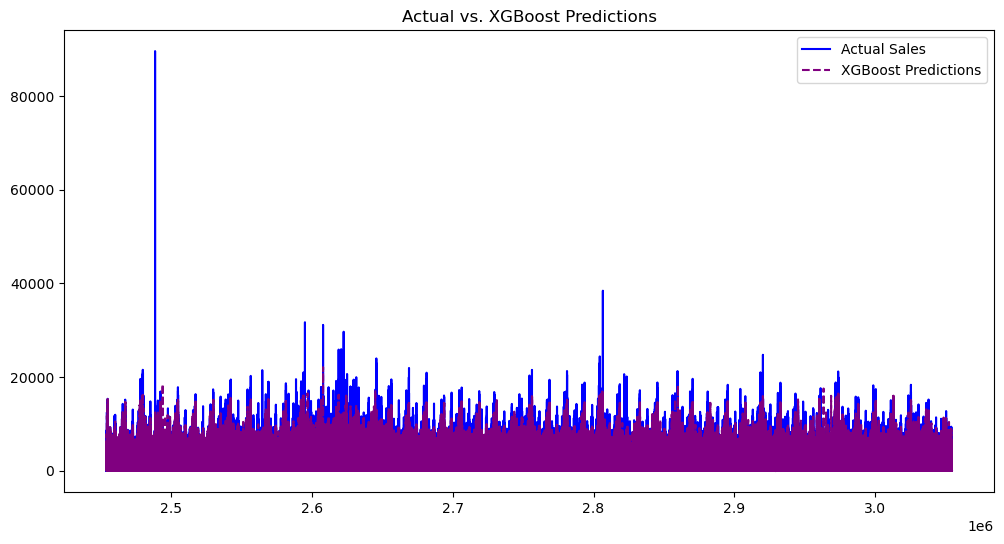

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label="Actual Sales", color='blue')
plt.plot(y_val.index, xgb_preds, label="XGBoost Predictions", color='purple', linestyle='dashed')
plt.title("Actual vs. XGBoost Predictions")
plt.legend()
plt.show()


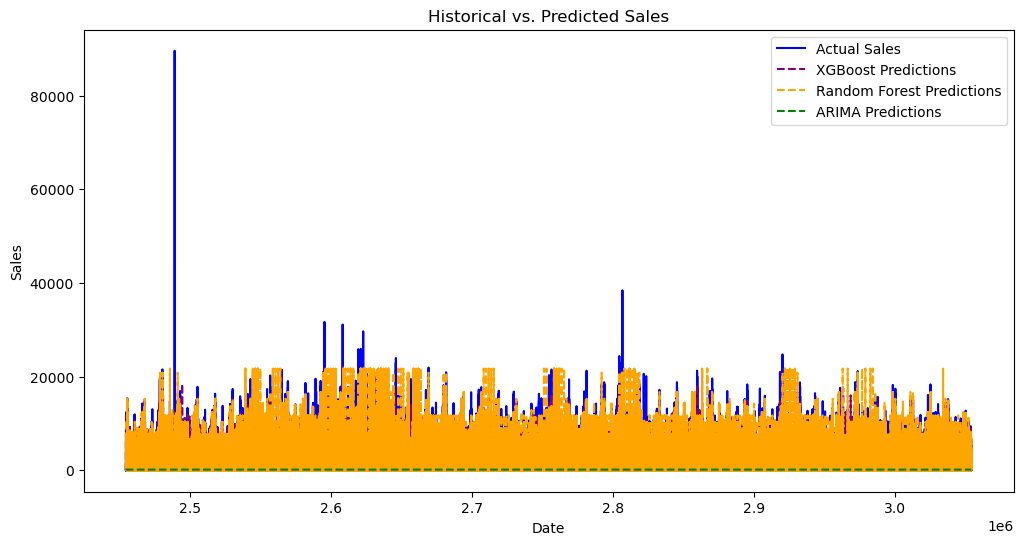

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label="Actual Sales", color='blue')
plt.plot(y_val.index, xgb_preds, label="XGBoost Predictions", color='purple', linestyle='dashed')
plt.plot(y_val.index, rf_preds, label="Random Forest Predictions", color='orange', linestyle='dashed')
plt.plot(y_val.index, arima_preds, label="ARIMA Predictions", color='green', linestyle='dashed')
plt.title("Historical vs. Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


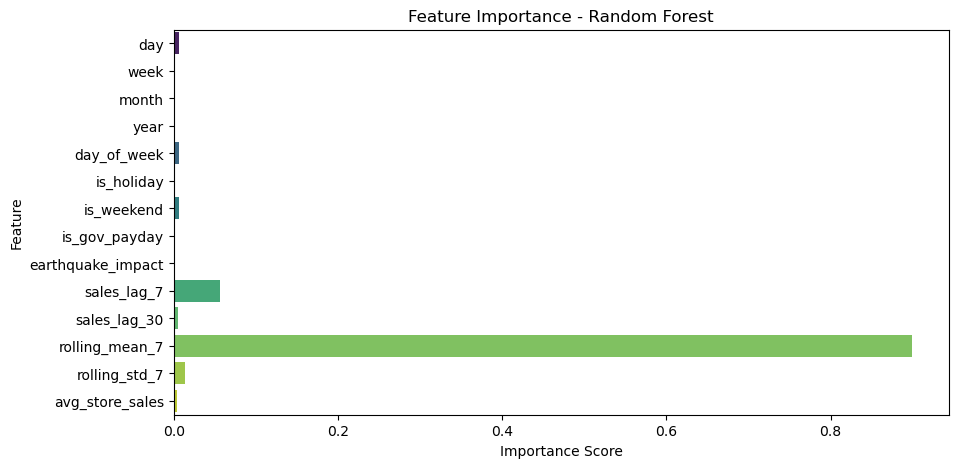

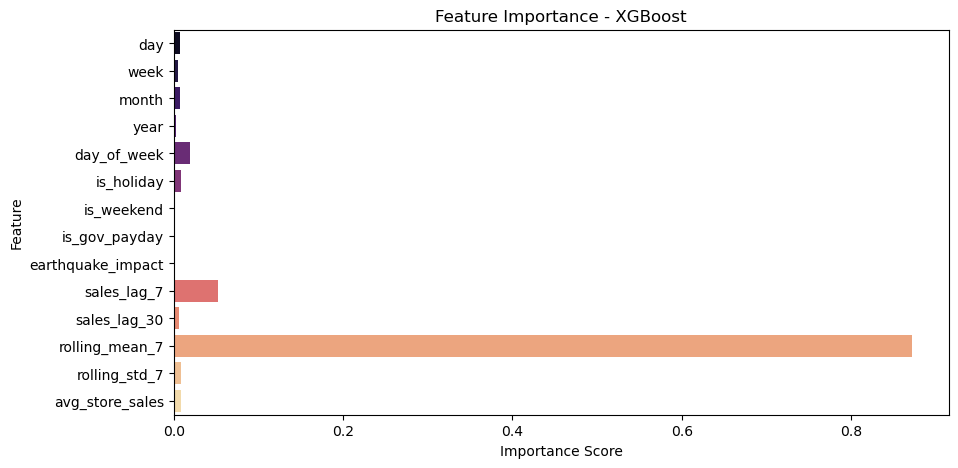

In [21]:
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_

features = X_train.columns


plt.figure(figsize=(10,5))
sns.barplot(x=importances_rf, y=features, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=importances_xgb, y=features, palette="magma")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


XGBoost is the best model because:

It has the lowest RMSE (307.43) → Least error in predictions.
It has the highest R² (0.95) → Explains 95% of sales variation, meaning it fits the data well.
It has a lower MAPE than the other models (though the absolute MAPE values seem extremely large and might need further verification).

Holidays & Events

Impact: Sales spiked during national holidays (e.g., Christmas, New Year) and special promotions.
Model Influence: XGBoost effectively captured these spikes, while ARIMA struggled due to its inability to handle sudden variations.

Business Strategy:
 Inventory Planning: Stock high-demand products before peak seasons.
 Staffing Adjustments: Increase workforce during high-sales periods.

 Oil Prices 

Impact: Sales showed some correlation with oil price fluctuations, as Ecuador's economy is influenced by fuel costs.
Model Influence: XGBoost captured long-term effects of economic trends, while Random Forest provided reasonable accuracy but lacked time dependency.
Example:
Rising oil prices → Higher transportation costs → Consumers may reduce discretionary spending.
Falling oil prices → More disposable income → Increased retail sales.
 Business Strategy:
 Dynamic Pricing: Adjust product prices based on economic conditions.
 Sales Promotions: Offer discounts when oil prices rise to encourage spending.

Promotions and Discounts 

Impact:
Sales increased significantly on days when products were on promotion.
The effect varied by product category (e.g., groceries had stronger responses than luxury goods).
Model Influence:
XGBoost and Random Forest captured promotional effects well.
ARIMA ignored promotions, leading to poor accuracy.